In [42]:
# imports
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import neurokit2 as nk
#import biobss from local to run without installing
sys.path.append("../")
import biobss


In [43]:
# Load sample EDA(GSR) data
sample_data = pd.read_pickle("../sample_data/EDA_Chest.pkl")
# Flatten the data
sample_data = sample_data.flatten()
# Sample Data Properties
sampling_rate = 700
# Create a timestamp for plotting, this is not necessary for the pipeline
timestamp = np.arange(0, len(sample_data)/sampling_rate, 1/sampling_rate)

In [44]:
# # Plot the data
# ax=plt.subplot(1,1,1)
# ax.figure.set_size_inches(16, 3)
# biobss.plottools.create_signal_plot(sample_data, ax, timestamp, 's', 'EDA Signal', 'EDA', None)

# <font color='Green'> Adding processes to the Pipeline </font>

#### <font color='red'> Adding a process </font>

Any process can be added to the pipeline if the input is a signal and ouput is a signal or collection of signals. The process can be added by passing the method to a Bio_Process constructor. The Bio_Process constructor takes the following arguments:

- process_method: The method to be added to the pipeline
- inplace: If True, result of the process will modify the input signal. If False, the result of the process will be returned as a new signal and added as a new channel.
- prefix: The prefix to be added to the output channel name. If inplace is True, prefix will be ignored.
  - If inplace is False, the output channel name will be prefix + input channel name.
  - <code> (Default: None) (if inplace = False  and prefix = None, prefix will be set to 'processed') </code>
- return_index : If a return_index is set, selected index of the result will be set as result. If return_index is None, the whole result will be set as result. (Default: None)
- argmap: this dictionary maps different named arguments. For example, Bio_Channel already have a sampling_rate attribute. If the process method requires sampling rate with a different name, it can be mapped to the Bio_Channel attribute.<code> EXAMPLE : argmap = {'sampling_rate': 'fs'} or argmap = {'sampling_rate': 'sample_rate'} </code>
- **kwargs: Keyword arguments to be passed to the process method






Pipeline processes the given input sequentially. The input is passed from one process to the next.

In [45]:
# Create steps for the pipeline
# EDA decopmosition step, Returns a dictionary with the following keys: EDA_Tonic, EDA_Phasic
decompose = biobss.pipeline.Bio_Process(process_name='decompose',process_method=biobss.edatools.eda_decompose,method="highpass")

# Filter steps process,return filtered signal for all input signals
clean=biobss.pipeline.Bio_Process(process_name='clean',
    process_method=biobss.edatools.eda_clean,method="neurokit")

# Signal normalization step, return normalized signal for all input signals
normalize = biobss.pipeline.Bio_Process(process_name='normalize',
    process_method=biobss.preprocess.normalize_signal)

# Signal resampling step, return resampled signal for all input signals, signals resampled to 350Hz
resample = biobss.pipeline.Bio_Process(process_name='resample',
    process_method=biobss.preprocess.resample_signal_object,target_sample_rate=350)

# Create feature extraction steps

# Extract signal features. input_signals dictionary contains feature prefixes as keys and input signals as values
# For example rms of EDA_Tonic is extracted as Tonic_rms in this case
signal_features = biobss.pipeline.Feature(name="signal_features", function=biobss.edatools.eda_signalfeatures.get_signal_features)

# Extract statistical features.
# For example mean of EDA_Tonic is extracted as Tonic_mean in this case
stat_features = biobss.pipeline.Feature(name="stat_features", function=biobss.edatools.get_stat_features)

In [46]:
# BIOBSS Pipeline is created
# windowed_process=True means that the pipeline will process the signal in windows
# window_size=60 means that the pipeline will process 60 seconds of data at a time
# step_size=20 means signal will be shifted by 20 seconds for each window
pipeline = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=60,step_size=20)

In [47]:
# Input is created as Bio_Channel object
# Bio_Channel object requires following parameters: name, signal, sampling_rate
# Optionally timestamp can be provided
# If timestamp is provided, resolution of the timestamp should be provided. Possible resolutions are:'min', 's', 'ms', 'us'
# If timestamp is not provided, timestamp will be created using sampling_rate. Default resolution is 's'
bio_channel=biobss.pipeline.Bio_Channel(signal=sample_data,name="EDA_Raw",sampling_rate=700)

# a Bio Channel object is created with sample data, with the name EDA_Raw and sampling rate 700
# timestamp is not provided, so timestamp will be created using sampling_rate

# Simply bio_channel the channel object will print the channel properties
bio_channel

EDA_Raw (700Hz) ((5920.0,)s) (1 windows) ((4144000,)) ((4144000,)) (float64)[5.40046692 5.40885925 5.40161133 ... 7.26280212 7.26966858 7.2681427 ]

In [48]:
# Pipeline input can be set from an array, a dataframe, pandas series, list, Bio_Channel, Bio_Data

# In this case, the pipeline input is set with an array
pipeline.set_input(sample_data,sampling_rate=700,name='EDA_Raw')

# Alternatively, the pipeline input can be set with a Bio_Channel object, in this case the name and sampling rate are not required as they are already provided in the Bio_Channel object
pipeline.set_input(bio_channel)

pipeline.input

Signal object with 1 channel(s)
EDA_Raw (700Hz) ((5920.0,)s) (1 windows) ((4144000,))

In [49]:
# Pipeline steps are added to the pipeline sequentially, the order of the steps is important as the output of one step is the input of the next step
# These steps will be processed in the order they are added to the pipeline
pipeline.preprocess_queue.add_process(clean,input_signals=['EDA_Raw'],output_signals=['EDA_Clean'])
pipeline.preprocess_queue.add_process(normalize,input_signals=['EDA_Clean'],output_signals=['EDA_Normalized'])
pipeline.preprocess_queue.add_process(decompose,input_signals=['EDA_Normalized'],output_signals=['EDA_Tonic','EDA_Phasic'])
pipeline.preprocess_queue.add_process(resample,input_signals=['EDA_Tonic'],output_signals=['EDA_Tonic'])
pipeline.preprocess_queue.add_process(resample,input_signals=['EDA_Phasic'],output_signals=['EDA_Phasic'])

# Currently all the steps are added to the preprocess_queue
# After the preprocess_queue is processed, data will be segmented into windows (if windowed_process=True)
# For running process in windows, the process_queue is used

## This structure will change in the future

In [50]:
# Features are added to the pipeline
pipeline.add_feature_step(signal_features,input_signals=['EDA_Tonic'],prefix='Tonic')
pipeline.add_feature_step(signal_features,input_signals=['EDA_Phasic'],prefix='Phasic')
pipeline.add_feature_step(stat_features,input_signals=['EDA_Tonic'],prefix='Tonic')
pipeline.add_feature_step(stat_features,input_signals=['EDA_Phasic'],prefix='Phasic')


In [51]:
# Represetation of the pipeline
pipeline

Bio_Pipeline:
	Preprocessors: Process list:
	1: clean(EDA_Raw) -> EDA_Clean
	2: normalize(EDA_Clean) -> EDA_Normalized
	3: decompose(EDA_Normalized) -> EDA_Tonic,EDA_Phasic
	4: resample(EDA_Tonic) -> EDA_Tonic
	5: resample(EDA_Phasic) -> EDA_Phasic

	Processors: Process list:

	Postprocessors: Process list:

	Window Size(Seconds): 60
	Step Size: 20

In [52]:
# Pipeline is run, this will process the input data in the pipeline
pipeline.run_pipeline()

..\biobss\pipeline\bioprocess_queue.py:74: UserWarning: If output of the process is Bio_Data, output signals argument must be a dictionary or it will bi ignored
  warn("If output of the process is Bio_Data, output signals argument must be a dictionary or it will bi ignored")


In [53]:
# Represetation of the pipeline data after running
pipeline.data

# Data is cleaned
# Data is normalized
# Data is decomposed into tonic and phasic components, these componenets are added to the pipeline data as EDA_Tonic and EDA_Phasic channels
# Lastly, data is resampled to 350Hz (All channels are resampled to 350Hz) (target_sample_rate=350)
# Data is segmented into windows of 60 seconds with a step size of 20 seconds

Signal object with 5 channel(s)
EDA_Raw (700Hz) (60.0s) (294 windows) ((294, 42000))
EDA_Clean (700Hz) (60.0s) (294 windows) ((294, 42000))
EDA_Normalized (700Hz) (60.0s) (294 windows) ((294, 42000))
EDA_Tonic (350Hz) (60.0s) (294 windows) ((294, 21000))
EDA_Phasic (350Hz) (60.0s) (294 windows) ((294, 21000))

In [54]:
# Statistical and signal features are extracted from the EDA_Tonic, EDA_Phasic and EDA_Raw channels
# Supplied prefix is added to the feature name
pipeline.extract_features()

In [55]:
# Represetation of the pipeline features after extraction
# Each row is a feature vector for a window
# index is the timestamp of the window (this can be selected as start, end or center of the window)
pipeline.features

,signal_rms,signal_acr_length,signal_integral,signal_average_power,signal_rms,signal_acr_length,signal_integral,signal_average_power,Tonic_mean,Tonic_std,...,Tonic_skew,Tonic_momentum,Phasic_mean,Phasic_std,Phasic_max,Phasic_min,Phasic_range,Phasic_kurtosis,Phasic_skew,Phasic_momentum
0.0,1.308357,20999.302980,27457.360721,1.711798,0.026455,20999.000076,315.451877,0.000700,-1.307493,0.047531,...,2.095446,0.002259,0.001101,0.026432,0.107763,-0.089481,0.197244,5.162175,0.612499,0.000699
20000.0,1.237605,20999.000013,25896.209117,1.531667,0.026826,20999.000084,334.686748,0.000720,-1.233153,0.104887,...,0.336681,0.011001,-0.000518,0.026821,0.107763,-0.089481,0.197244,4.875817,0.747219,0.000719
40000.0,1.167398,20999.000010,24424.712270,1.362819,0.032283,20999.000127,467.324039,0.001042,-1.163082,0.100299,...,-0.983479,0.010060,-0.001357,0.032254,0.107763,-0.089481,0.197244,2.081785,0.855737,0.001040
60000.0,1.127666,20999.000006,23652.997232,1.271631,0.022655,20999.000122,342.426683,0.000513,-1.126333,0.054812,...,-1.316493,0.003004,-0.001521,0.022604,0.099171,-0.040446,0.139617,3.444132,1.518407,0.000511
80000.0,1.212625,20999.000006,25359.433891,1.470459,0.021986,20999.000113,307.000735,0.000483,-1.207592,0.110366,...,-0.271838,0.012181,0.000120,0.021985,0.099171,-0.040446,0.139617,3.701695,1.442919,0.000483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5780000.0,0.892398,20999.000001,18739.063803,0.796373,0.005386,20999.000040,94.590501,0.000029,0.892336,0.010449,...,-0.158085,0.000109,-0.000373,0.005373,0.013347,-0.013719,0.027066,-0.720037,0.025223,0.000029
5800000.0,0.886614,20999.000002,18618.155856,0.786084,0.005476,20999.000038,95.100843,0.000030,0.886579,0.007858,...,0.272679,0.000062,0.000588,0.005444,0.013068,-0.013719,0.026787,-0.603541,0.023752,0.000030
5820000.0,0.915463,20999.000007,19184.082240,0.838073,0.013858,20999.000080,199.617533,0.000192,0.913528,0.059500,...,1.742078,0.003540,0.000855,0.013831,0.059136,-0.043795,0.102932,2.533057,0.148651,0.000191
5840000.0,0.965569,20999.000013,20218.380497,0.932323,0.021105,20999.000149,324.806396,0.000445,0.962780,0.073329,...,0.113404,0.005377,-0.000449,0.021100,0.062023,-0.059352,0.121375,0.865320,0.090870,0.000445


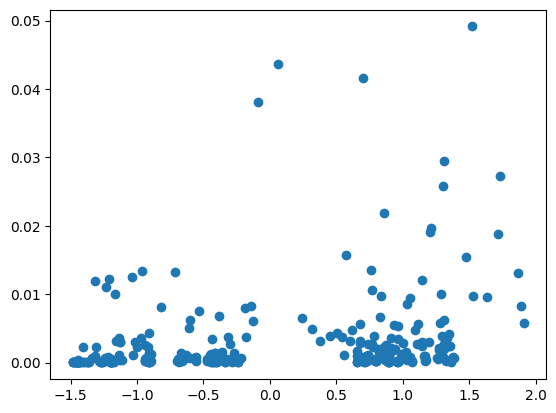

In [61]:
plt.scatter(pipeline.features['Tonic_mean'],pipeline.features['Tonic_momentum'])